# Выпускной проект по теме «Промышленность»

Металлургический комбинат «Стальная птица» решил уменьшить производственные расходы. Для этого необходимо уменьшить потребление электроэнергии на этапе обработки стали, как следствие, необходимо контролировать температуру сплава.

**Описание этапа обработки стали**

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша.\
Из сплава выводится сера (этот процесс — десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (от англ. tribe — «масса»).\
Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.\
Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (от англ. slab — «плита»).

**Описание данных**

Данные состоят из нескольких файлов, полученных из разных источников:
- data_arc_new.csv — данные об электродах;
- data_bulk_new.csv — данные о подаче сыпучих материалов (объём);
- data_bulk_time_new.csv — данные о подаче сыпучих материалов (время);
- data_gas_new.csv — данные о продувке сплава газом;
- data_temp_new.csv — результаты измерения температуры;
- data_wire_new.csv — данные о проволочных материалах (объём);
- data_wire_time_new.csv — данные о проволочных материалах (время).\

Во всех файлах столбец key содержит номер партии. В файлах может быть несколько строк с одинаковым значением key: они соответствуют разным итерациям обработки.

**План работы**

**1. Загрузка данных и исследовательский анализ**\
Загрузить данные из всех 7 файлов и сделать их первичный анализ. Провести исследовательский анализ каждого датафрейма\
**2. Предобработка данных**\
Привести названия столбцов к правильному виду, изменить тип данных, удалить аномалии в данных.\
**3. Объединение данных**\
Объединить отобранные признаки в один датафрейм по ключу.\
**4. Исследовательский анализ и предобработка данных объединённого датафрейма**\
Провести исследовательский анализ объединённого датафрейма. Провести корреляционный анализ.\
**5. Подготовка данных**\
Разделить данные на обучающую (75%) и тестовую (25%) выборки.\
**6. Обучение моделей машинного обучения и выбор лучшей модели**\
Обучить как минимум две модели. Для одной из них подобрать гиперпараметры. Выбрать лучшую модель и проверить её качество на тестовой выборке.\
**7. Общий вывод и рекомендации заказчику**

**Цель проекта:** 
Построение модели для предсказания конечной температуры сплава, что позволит уменьшить потребление электроэнергии и, как следствие, сократить производственные расходы комбината.

In [1]:
# импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.dummy import DummyRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from lightgbm.sklearn import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import shap

In [2]:
RANDOM_STATE = 91224
TEST_SIZE = 0.25

## Загрузка данных. Исследовательский анализ

In [3]:
# считывание csv-файлов и сохранение в датафреймы
data_arc_new = pd.read_csv('https://code.s3.yandex.net/datasets/data_arc_new.csv')
data_bulk_new = pd.read_csv('https://code.s3.yandex.net/datasets/data_bulk_new.csv')
data_bulk_time_new = pd.read_csv('https://code.s3.yandex.net/datasets/data_bulk_time_new.csv')
data_gas_new = pd.read_csv('https://code.s3.yandex.net/datasets/data_gas_new.csv')
data_temp_new = pd.read_csv('https://code.s3.yandex.net/datasets/data_temp_new.csv')
data_wire_new = pd.read_csv('https://code.s3.yandex.net/datasets/data_wire_new.csv')
data_wire_time_new = pd.read_csv('https://code.s3.yandex.net/datasets/data_wire_time_new.csv')

In [4]:
# вывод первых 5 строк датафрейма
data_arc_new.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691


In [5]:
# вывод основной информации о датафрейме
data_arc_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


In [6]:
# вывод числового описания данных
data_arc_new.describe()

,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.662752,0.438986
std,934.571502,0.258885,5.873485
min,1.000000,0.223120,-715.479924
25%,806.000000,0.467115,0.337175
50%,1617.000000,0.599587,0.441639
75%,2429.000000,0.830070,0.608201
max,3241.000000,1.463773,1.270284


В столбце "Реактивная мощность" датафрейма data_arc_new наблюдается аномалия, так как минимальное значение < 0.

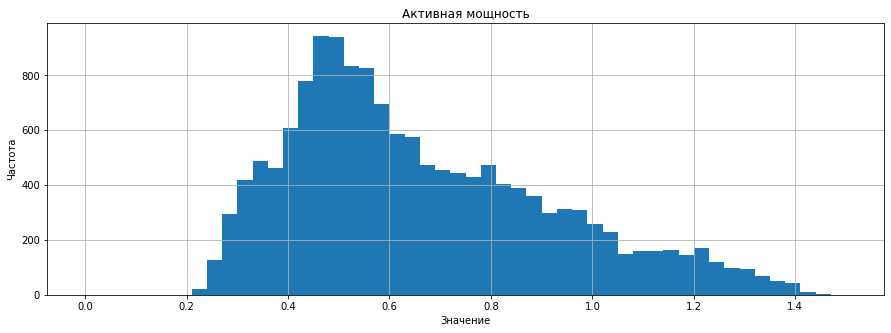

In [7]:
# построение гистограммы по столбцу 'Активная мощность'
data_arc_new['Активная мощность'].hist(bins=50, range = (0, 1.5), figsize=(15, 5))
plt.title('Активная мощность')
plt.ylabel('Частота')
plt.xlabel('Значение');

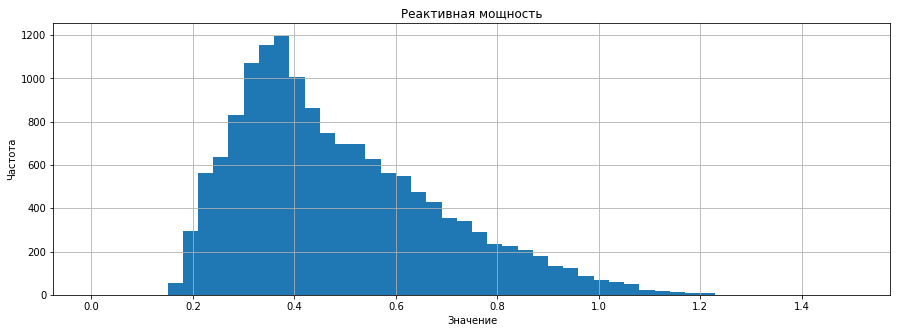

In [8]:
# построение гистограммы по столбцу 'Реактивная мощность'
data_arc_new['Реактивная мощность'].hist(bins=50, range = (0, 1.5), figsize=(15, 5))
plt.title('Реактивная мощность')
plt.ylabel('Частота')
plt.xlabel('Значение');

In [9]:
# подсчет количества пропусков
data_arc_new.isna().sum()

key                     0
Начало нагрева дугой    0
Конец нагрева дугой     0
Активная мощность       0
Реактивная мощность     0
dtype: int64

In [10]:
# вывод первых 5 строк датафрейма
data_bulk_new.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


In [11]:
# вывод основной информации о датафрейме
data_bulk_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


In [12]:
# вывод числового описания данных
data_bulk_new.describe()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


In [13]:
# подсчет количества пропусков
data_bulk_new.isna().sum()

key           0
Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5     3052
Bulk 6     2553
Bulk 7     3104
Bulk 8     3128
Bulk 9     3110
Bulk 10    2953
Bulk 11    2952
Bulk 12     679
Bulk 13    3111
Bulk 14     323
Bulk 15     881
dtype: int64

In [14]:
# вывод первых 5 строк датафрейма
data_bulk_time_new.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:28:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:24:31,NaN,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaN,NaN,NaN,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:53:30,NaN,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaN,NaN,NaN,2019-05-03 12:32:39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:27:13,NaN,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaN,NaN,NaN,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:58:00,NaN,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,2019-05-03 13:34:12,2019-05-03 13:30:47


In [15]:
# вывод основной информации о датафрейме
data_bulk_time_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


In [16]:
# подсчет количества пропусков
data_bulk_time_new.isna().sum()

key           0
Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5     3052
Bulk 6     2553
Bulk 7     3104
Bulk 8     3128
Bulk 9     3110
Bulk 10    2953
Bulk 11    2952
Bulk 12     679
Bulk 13    3111
Bulk 14     323
Bulk 15     881
dtype: int64

In [17]:
# вывод первых 5 строк датафрейма
data_gas_new.head()

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


In [18]:
# вывод основной информации о датафрейме
data_gas_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


In [19]:
# вывод числового описания данных
data_gas_new.describe()

,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


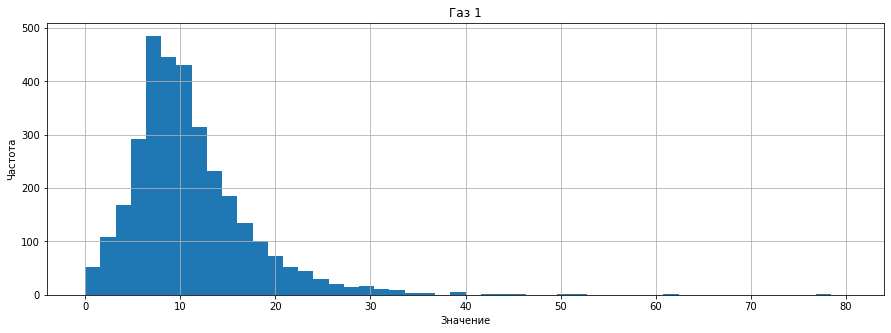

In [20]:
# построение гистограммы по столбцу 'Газ 1'
data_gas_new['Газ 1'].hist(bins=50, range = (0, 80), figsize=(15, 5))
plt.title('Газ 1')
plt.ylabel('Частота')
plt.xlabel('Значение');

In [21]:
# подсчет количества пропусков
data_gas_new.isna().sum()

key      0
Газ 1    0
dtype: int64

In [22]:
# вывод первых 5 строк датафрейма
data_temp_new.head()

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0


In [23]:
# вывод основной информации о датафрейме
data_temp_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           18092 non-null  int64  
 1   Время замера  18092 non-null  object 
 2   Температура   14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB


In [24]:
# вывод числового описания данных
data_temp_new.describe()

,key,Температура
count,18092.000000,14665.000000
mean,1616.460977,1590.722741
std,934.641385,20.394381
min,1.000000,1191.000000
25%,807.750000,1580.000000
50%,1618.000000,1590.000000
75%,2429.000000,1599.000000
max,3241.000000,1705.000000


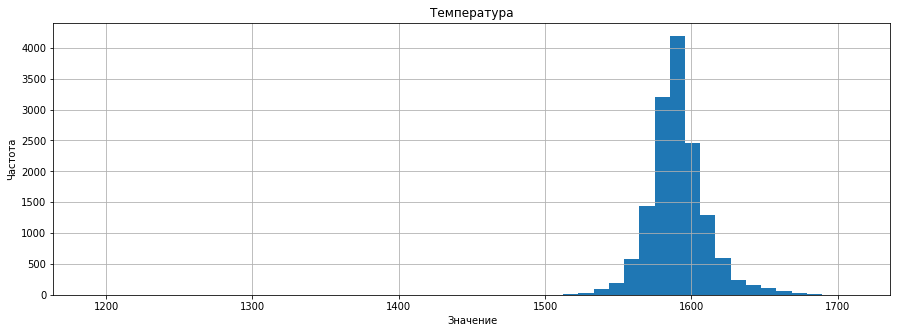

In [25]:
# построение гистограммы по столбцу 'Температура'
data_temp_new['Температура'].hist(bins=50, range = (1190, 1710), figsize=(15, 5))
plt.title('Температура')
plt.ylabel('Частота')
plt.xlabel('Значение');

In [26]:
# подсчет количества пропусков
data_temp_new.isna().sum()

key                0
Время замера       0
Температура     3427
dtype: int64

In [27]:
# вывод первых 5 строк датафрейма
data_wire_new.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
# вывод основной информации о датафрейме
data_wire_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


In [29]:
# вывод числового описания данных
data_wire_new.describe()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


In [30]:
# подсчет количества пропусков
data_wire_new.isna().sum()

key          0
Wire 1      26
Wire 2    2002
Wire 3    3018
Wire 4    3067
Wire 5    3080
Wire 6    3008
Wire 7    3070
Wire 8    3062
Wire 9    3052
dtype: int64

In [31]:
# вывод первых 5 строк датафрейма
data_wire_time_new.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:11:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
# вывод основной информации о датафрейме
data_wire_time_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


In [33]:
# подсчет количества пропусков
data_wire_time_new.isna().sum()

key          0
Wire 1      26
Wire 2    2002
Wire 3    3018
Wire 4    3067
Wire 5    3080
Wire 6    3008
Wire 7    3070
Wire 8    3062
Wire 9    3052
dtype: int64

**Вывод по первому этапу:**\
Были загружены данные всех 7-ми датафреймов. В результате первичной обработки было выяснено, что датафреймы data_wire_time_new, data_wire_new, data_temp_new, data_bulk_time_new, data_bulk_new имеют пропуски. Также были замечаны аномалии в виде отрицательных значений в столбце "Реактивная мощность" датафрейма data_arc_new. По графику температур видно, что наибольшее кол-во значение приходится на промежуток от 1500 до 1700. Наибольшее кол-во значений газа лежат в промежутке от 0 до 20.    

## Предобработка данных

In [34]:
# переименование столбцов
data_arc_new = data_arc_new.rename(columns={'Начало нагрева дугой':'start_arc_heating', 
                                            'Конец нагрева дугой':'end_arc_heating', 
                                            'Активная мощность':'active_power',
                                            'Реактивная мощность':'reactive_power'
                                           })

In [35]:
# вывод первых 5 строк датафрейма
data_arc_new.head()

,key,start_arc_heating,end_arc_heating,active_power,reactive_power
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691


In [36]:
# изменение типа данных столбца start_arc_heating
data_arc_new['start_arc_heating'] = pd.to_datetime(data_arc_new['start_arc_heating'],
                                                   format = '%Y-%m-%d %H:%M:%S')

In [37]:
# изменение типа данных столбца end_arc_heating
data_arc_new['end_arc_heating'] = pd.to_datetime(data_arc_new['end_arc_heating'],
                                                   format = '%Y-%m-%d %H:%M:%S')

In [38]:
# вывод основной информации о датафрейме
data_arc_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   key                14876 non-null  int64         
 1   start_arc_heating  14876 non-null  datetime64[ns]
 2   end_arc_heating    14876 non-null  datetime64[ns]
 3   active_power       14876 non-null  float64       
 4   reactive_power     14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB


In [39]:
# срез для удаления отрицательных значений в столбце reactive_power
data_arc_new = data_arc_new.query('reactive_power >= 0')

In [40]:
data_arc_new['arc_heating_time'] = data_arc_new['end_arc_heating'] - data_arc_new['start_arc_heating']
data_arc_new['arc_heating_time'] = data_arc_new['arc_heating_time'].dt.seconds
data_arc_new.head()

,key,start_arc_heating,end_arc_heating,active_power,reactive_power,arc_heating_time
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,228
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,185
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,172
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979,365
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691,148


In [41]:
# группировка значений по столбцу key
data_arc_new = data_arc_new.groupby(by='key').sum()

In [42]:
# вывод обновленного датафрейма data_arc_new
data_arc_new.head()

,active_power,reactive_power,arc_heating_time
key,,,
1,3.036730,2.142821,1098
2,2.139408,1.453357,811
3,4.063641,2.937457,655
4,2.706489,2.056992,741
5,2.252950,1.687991,869


In [43]:
# переименование столбцов data_bulk_new
data_bulk_new = data_bulk_new.rename(columns={'Bulk 1':'bulk_1', 'Bulk 2':'bulk_2', 'Bulk 3':'bulk_3', 'Bulk 4':'bulk_4',
                                              'Bulk 5':'bulk_5', 'Bulk 6':'bulk_6', 'Bulk 7':'bulk_7', 'Bulk 8':'bulk_8',
                                              'Bulk 9':'bulk_9', 'Bulk 10':'bulk_10', 'Bulk 11':'bulk_11', 'Bulk 12':'bulk_12',
                                              'Bulk 13':'bulk_13', 'Bulk 14':'bulk_14', 'Bulk 15':'bulk_15'
                                             })

In [44]:
# вывод первых 5 строк датафрейма
data_bulk_new.head()

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


In [45]:
# переименование столбцов датафрейма data_bulk_time_new
data_bulk_time_new = data_bulk_time_new.rename(columns={'Bulk 1':'bulk_1', 'Bulk 2':'bulk_2', 'Bulk 3':'bulk_3', 
                                                        'Bulk 4':'bulk_4', 'Bulk 5':'bulk_5', 'Bulk 6':'bulk_6',
                                                        'Bulk 7':'bulk_7', 'Bulk 8':'bulk_8', 'Bulk 9':'bulk_9',
                                                        'Bulk 10':'bulk_10', 'Bulk 11':'bulk_11', 'Bulk 12':'bulk_12',
                                                        'Bulk 13':'bulk_13', 'Bulk 14':'bulk_14', 'Bulk 15':'bulk_15'
                                                       })

In [46]:
# переименование столбцов датафрейма data_gas_new
data_gas_new = data_gas_new.rename(columns={'Газ 1':'gas_1'})

In [47]:
# переименование столбцов датафрейма data_temp_new
data_temp_new = data_temp_new.rename(columns={'Время замера':'measurement_time', 'Температура':'temperature'})

In [48]:
# изменение типа данных столбца measurement_time
data_temp_new['measurement_time'] = pd.to_datetime(data_temp_new['measurement_time'],
                                                   format = '%Y-%m-%d %H:%M:%S')

In [49]:
# срез для удаления значений в столбце temperature
data_temp_new = data_temp_new.query('temperature > 1500')
data_temp_new

,key,measurement_time,temperature
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0
...,...,...,...
18061,3237,2019-09-06 11:31:15,1569.0
18067,3238,2019-09-06 12:16:15,1584.0
18071,3239,2019-09-06 14:16:50,1598.0
18080,3240,2019-09-06 15:25:21,1617.0


In [50]:
# определение количества измерений от ключа
number_measurements = pd.DataFrame(data_temp_new['key'].value_counts())

In [51]:
number_measurements

,key
2108,17
1513,16
1689,16
46,14
322,14
...,...
3236,1
2963,1
2955,1
2947,1


In [52]:
# добавление столбца с индексами
number_measurements = number_measurements.reset_index()

In [53]:
# переименование столбцов
number_measurements.columns = ['key', 'count']
number_measurements.head()

,key,count
0,2108,17
1,1513,16
2,1689,16
3,46,14
4,322,14


In [54]:
# срез для удаления значений с одним замером температуры
number_measurements = number_measurements.query('count > 1')
number_measurements.tail()

,key,count
2470,2194,2
2471,1449,2
2472,530,2
2473,2112,2
2474,269,2


In [55]:
# объединение датафреймов data_temp_new и number_measurements по столбцу key
data_temp_new = data_temp_new.merge(number_measurements['key'], on='key', how='right')
data_temp_new.head()

,key,measurement_time,temperature
0,2108,2019-07-27 10:41:03,1639.0
1,2108,2019-07-27 11:07:14,1626.0
2,2108,2019-07-27 11:13:27,1604.0
3,2108,2019-07-27 11:15:35,1612.0
4,2108,2019-07-27 11:19:16,1621.0


In [56]:
data_temp_new = data_temp_new.groupby(by = 'key').agg(['first', 'last']).reset_index()
data_temp_new.columns = ['key', 'start_time', 'end_time', 'start_temp', 'end_temp']
data_temp_new

,key,start_time,end_time,start_temp,end_temp
0,1,2019-05-03 11:02:04,2019-05-03 11:30:38,1571.0,1613.0
1,2,2019-05-03 11:34:04,2019-05-03 11:55:09,1581.0,1602.0
2,3,2019-05-03 12:06:44,2019-05-03 12:35:57,1596.0,1599.0
3,4,2019-05-03 12:39:27,2019-05-03 12:59:47,1601.0,1625.0
4,5,2019-05-03 13:11:03,2019-05-03 13:36:39,1576.0,1602.0
...,...,...,...,...,...
2470,2495,2019-08-10 11:27:47,2019-08-10 11:50:47,1570.0,1591.0
2471,2496,2019-08-10 11:56:48,2019-08-10 12:25:13,1554.0,1591.0
2472,2497,2019-08-10 12:37:26,2019-08-10 12:53:28,1571.0,1589.0
2473,2498,2019-08-10 12:58:11,2019-08-10 13:23:31,1591.0,1594.0


In [57]:
# объединение датафреймов data_temp_new и number_measurements по столбцу key
data_temp_new = data_temp_new.merge(number_measurements, on='key', how='right')
data_temp_new.head()

,key,start_time,end_time,start_temp,end_temp,count
0,2108,2019-07-27 10:41:03,2019-07-27 16:36:34,1639.0,1541.0,17
1,1513,2019-06-29 05:41:20,2019-06-29 08:56:12,1553.0,1574.0,16
2,1689,2019-07-05 08:07:11,2019-07-05 14:41:45,1583.0,1606.0,16
3,46,2019-05-05 03:52:46,2019-05-05 07:18:09,1607.0,1612.0,14
4,322,2019-05-15 21:12:18,2019-05-15 23:09:09,1619.0,1616.0,14


In [58]:
# переименование столбцов датафрейма data_wire_new
data_wire_new = data_wire_new.rename(columns={'Wire 1':'wire_1', 'Wire 2':'wire_2', 'Wire 3':'wire_3', 
                                              'Wire 4':'wire_4', 'Wire 5':'wire_5', 'Wire 6':'wire_6',
                                              'Wire 7':'wire_7', 'Wire 8':'wire_8', 'Wire 9':'wire_9',
                                             })

In [59]:
# переименование столбцов датафрейма data_wire_time_new
data_wire_time_new = data_wire_time_new.rename(columns={'Wire 1':'wire_1', 'Wire 2':'wire_2', 'Wire 3':'wire_3', 
                                                        'Wire 4':'wire_4', 'Wire 5':'wire_5', 'Wire 6':'wire_6',
                                                        'Wire 7':'wire_7', 'Wire 8':'wire_8', 'Wire 9':'wire_9',
                                                       })

In [60]:
data_wire_time_new.head()

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1,2019-05-03 11:06:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:11:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Вывод по второму этапу:**\
На втором этапе были изменены наименования столбцов во всех датафреймах и приведены к правильному виду. Также были изменены типы данных в столбцах start_arc_heating, end_arc_heating датафрейма data_arc_new и в столбце measurement_time датафрейма data_temp_new. Были удалены строки со значением реактивной мощности < 0 в датафрейме data_arc_new и строки со значением температуры < 1500 в датафрейме data_temp_new. В датафрейме data_temp_new удаляем ключи с одним замером температуры. В датафрейм data_arc_new добавили новый столбец arc_heating_time - время нагрева дугой. В датафрейм data_temp_new были добавлены столбцы 'start_time', 'end_time', 'start_temp', 'end_temp' и 'count'.     

## Объединение датасетов

In [61]:
# объединение всех датасетов
data = data_arc_new.merge(data_bulk_new, on='key', how='inner')
data = data.merge(data_gas_new, on='key', how='inner')
data = data.merge(data_temp_new, on='key', how='inner')
data = data.merge(data_wire_new, on='key', how='inner')
data.head()

,key,active_power,reactive_power,arc_heating_time,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,...,count,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1,3.036730,2.142821,1098,NaN,NaN,NaN,43.0,NaN,NaN,...,6,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2.139408,1.453357,811,NaN,NaN,NaN,73.0,NaN,NaN,...,5,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,4.063641,2.937457,655,NaN,NaN,NaN,34.0,NaN,NaN,...,6,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2.706489,2.056992,741,NaN,NaN,NaN,81.0,NaN,NaN,...,5,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2.252950,1.687991,869,NaN,NaN,NaN,78.0,NaN,NaN,...,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [62]:
# вывод основной информации о новом датафрейме data
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2329 entries, 0 to 2328
Data columns (total 34 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   key               2329 non-null   int64         
 1   active_power      2329 non-null   float64       
 2   reactive_power    2329 non-null   float64       
 3   arc_heating_time  2329 non-null   int64         
 4   bulk_1            199 non-null    float64       
 5   bulk_2            13 non-null     float64       
 6   bulk_3            960 non-null    float64       
 7   bulk_4            812 non-null    float64       
 8   bulk_5            53 non-null     float64       
 9   bulk_6            438 non-null    float64       
 10  bulk_7            13 non-null     float64       
 11  bulk_8            1 non-null      float64       
 12  bulk_9            13 non-null     float64       
 13  bulk_10           143 non-null    float64       
 14  bulk_11           130 no

In [63]:
# подсчет количества пропусков
data.isna().sum()

key                    0
active_power           0
reactive_power         0
arc_heating_time       0
bulk_1              2130
bulk_2              2316
bulk_3              1369
bulk_4              1517
bulk_5              2276
bulk_6              1891
bulk_7              2316
bulk_8              2328
bulk_9              2316
bulk_10             2186
bulk_11             2199
bulk_12              517
bulk_13             2315
bulk_14              261
bulk_15              630
gas_1                  0
start_time             0
end_time               0
start_temp             0
end_temp               0
count                  0
wire_1                23
wire_2              1518
wire_3              2290
wire_4              2317
wire_5              2329
wire_6              2284
wire_7              2325
wire_8              2316
wire_9              2305
dtype: int64

In [64]:
# удаление столбцов, в которых более 80% пропуски
data = data.drop(['bulk_1', 'bulk_2', 'bulk_5', 'bulk_7', 'bulk_8', 'bulk_9', 'bulk_10', 'bulk_11', 'bulk_13', 
                  'wire_3', 'wire_4', 'wire_5', 'wire_6', 'wire_7', 'wire_8', 'wire_9'], axis=1)
data.tail()

,key,active_power,reactive_power,arc_heating_time,bulk_3,bulk_4,bulk_6,bulk_12,bulk_14,bulk_15,gas_1,start_time,end_time,start_temp,end_temp,count,wire_1,wire_2
2324,2495,3.168133,2.210936,723,21.0,NaN,NaN,256.0,129.0,223.0,7.125735,2019-08-10 11:27:47,2019-08-10 11:50:47,1570.0,1591.0,5,89.150879,NaN
2325,2496,4.174918,2.872031,940,NaN,63.0,NaN,256.0,129.0,226.0,9.412616,2019-08-10 11:56:48,2019-08-10 12:25:13,1554.0,1591.0,7,114.179527,NaN
2326,2497,3.605239,2.452092,569,NaN,85.0,NaN,230.0,124.0,226.0,6.271699,2019-08-10 12:37:26,2019-08-10 12:53:28,1571.0,1589.0,4,94.086723,9.04800
2327,2498,3.202310,2.239820,750,90.0,NaN,NaN,206.0,129.0,207.0,14.953657,2019-08-10 12:58:11,2019-08-10 13:23:31,1591.0,1594.0,6,118.110717,NaN
2328,2499,1.737084,1.296836,883,47.0,NaN,NaN,233.0,126.0,227.0,11.336151,2019-08-10 13:33:21,2019-08-10 13:58:58,1569.0,1603.0,5,110.160958,50.00528


In [65]:
# замена всех значений Nan на 0
data = data.fillna(0)

In [66]:
# удаление столбца key
data = data.drop('key', axis=1)
data.head()

,active_power,reactive_power,arc_heating_time,bulk_3,bulk_4,bulk_6,bulk_12,bulk_14,bulk_15,gas_1,start_time,end_time,start_temp,end_temp,count,wire_1,wire_2
0,3.036730,2.142821,1098,0.0,43.0,0.0,206.0,150.0,154.0,29.749986,2019-05-03 11:02:04,2019-05-03 11:30:38,1571.0,1613.0,6,60.059998,0.00000
1,2.139408,1.453357,811,0.0,73.0,0.0,206.0,149.0,154.0,12.555561,2019-05-03 11:34:04,2019-05-03 11:55:09,1581.0,1602.0,5,96.052315,0.00000
2,4.063641,2.937457,655,0.0,34.0,0.0,205.0,152.0,153.0,28.554793,2019-05-03 12:06:44,2019-05-03 12:35:57,1596.0,1599.0,6,91.160157,0.00000
3,2.706489,2.056992,741,0.0,81.0,0.0,207.0,153.0,154.0,18.841219,2019-05-03 12:39:27,2019-05-03 12:59:47,1601.0,1625.0,5,89.063515,0.00000
4,2.252950,1.687991,869,0.0,78.0,0.0,203.0,151.0,152.0,5.413692,2019-05-03 13:11:03,2019-05-03 13:36:39,1576.0,1602.0,5,89.238236,9.11456


In [67]:
# добавление нового признака 'полная мощность' 
data['full_power'] = (data['active_power']**2 + data['reactive_power']**2)**0.5
data.head()

,active_power,reactive_power,arc_heating_time,bulk_3,bulk_4,bulk_6,bulk_12,bulk_14,bulk_15,gas_1,start_time,end_time,start_temp,end_temp,count,wire_1,wire_2,full_power
0,3.036730,2.142821,1098,0.0,43.0,0.0,206.0,150.0,154.0,29.749986,2019-05-03 11:02:04,2019-05-03 11:30:38,1571.0,1613.0,6,60.059998,0.00000,3.716640
1,2.139408,1.453357,811,0.0,73.0,0.0,206.0,149.0,154.0,12.555561,2019-05-03 11:34:04,2019-05-03 11:55:09,1581.0,1602.0,5,96.052315,0.00000,2.586371
2,4.063641,2.937457,655,0.0,34.0,0.0,205.0,152.0,153.0,28.554793,2019-05-03 12:06:44,2019-05-03 12:35:57,1596.0,1599.0,6,91.160157,0.00000,5.014163
3,2.706489,2.056992,741,0.0,81.0,0.0,207.0,153.0,154.0,18.841219,2019-05-03 12:39:27,2019-05-03 12:59:47,1601.0,1625.0,5,89.063515,0.00000,3.399456
4,2.252950,1.687991,869,0.0,78.0,0.0,203.0,151.0,152.0,5.413692,2019-05-03 13:11:03,2019-05-03 13:36:39,1576.0,1602.0,5,89.238236,9.11456,2.815155


In [68]:
# добавление нового признака 'разница времени'
data['difference_time'] = data['end_time'] - data['start_time']
data['difference_time'] = data['difference_time'].dt.seconds
data.head()

,active_power,reactive_power,arc_heating_time,bulk_3,bulk_4,bulk_6,bulk_12,bulk_14,bulk_15,gas_1,start_time,end_time,start_temp,end_temp,count,wire_1,wire_2,full_power,difference_time
0,3.036730,2.142821,1098,0.0,43.0,0.0,206.0,150.0,154.0,29.749986,2019-05-03 11:02:04,2019-05-03 11:30:38,1571.0,1613.0,6,60.059998,0.00000,3.716640,1714
1,2.139408,1.453357,811,0.0,73.0,0.0,206.0,149.0,154.0,12.555561,2019-05-03 11:34:04,2019-05-03 11:55:09,1581.0,1602.0,5,96.052315,0.00000,2.586371,1265
2,4.063641,2.937457,655,0.0,34.0,0.0,205.0,152.0,153.0,28.554793,2019-05-03 12:06:44,2019-05-03 12:35:57,1596.0,1599.0,6,91.160157,0.00000,5.014163,1753
3,2.706489,2.056992,741,0.0,81.0,0.0,207.0,153.0,154.0,18.841219,2019-05-03 12:39:27,2019-05-03 12:59:47,1601.0,1625.0,5,89.063515,0.00000,3.399456,1220
4,2.252950,1.687991,869,0.0,78.0,0.0,203.0,151.0,152.0,5.413692,2019-05-03 13:11:03,2019-05-03 13:36:39,1576.0,1602.0,5,89.238236,9.11456,2.815155,1536


In [69]:
# добавление нового признака 'работа'
data['work'] = data['full_power'] * data['difference_time']
data.head()

,active_power,reactive_power,arc_heating_time,bulk_3,bulk_4,bulk_6,bulk_12,bulk_14,bulk_15,gas_1,start_time,end_time,start_temp,end_temp,count,wire_1,wire_2,full_power,difference_time,work
0,3.036730,2.142821,1098,0.0,43.0,0.0,206.0,150.0,154.0,29.749986,2019-05-03 11:02:04,2019-05-03 11:30:38,1571.0,1613.0,6,60.059998,0.00000,3.716640,1714,6370.320508
1,2.139408,1.453357,811,0.0,73.0,0.0,206.0,149.0,154.0,12.555561,2019-05-03 11:34:04,2019-05-03 11:55:09,1581.0,1602.0,5,96.052315,0.00000,2.586371,1265,3271.758877
2,4.063641,2.937457,655,0.0,34.0,0.0,205.0,152.0,153.0,28.554793,2019-05-03 12:06:44,2019-05-03 12:35:57,1596.0,1599.0,6,91.160157,0.00000,5.014163,1753,8789.827951
3,2.706489,2.056992,741,0.0,81.0,0.0,207.0,153.0,154.0,18.841219,2019-05-03 12:39:27,2019-05-03 12:59:47,1601.0,1625.0,5,89.063515,0.00000,3.399456,1220,4147.335907
4,2.252950,1.687991,869,0.0,78.0,0.0,203.0,151.0,152.0,5.413692,2019-05-03 13:11:03,2019-05-03 13:36:39,1576.0,1602.0,5,89.238236,9.11456,2.815155,1536,4324.077983


**Вывод по третьему этапу:**\
На третьем этапе данные датафреймов data_arc_new, data_bulk_new, data_gas_new, data_temp_new, data_wire_new были объединены в один датафрейм по столбцу 'key', который впоследствии был удален. Также были удалены столбцы 'bulk_1', 'bulk_2', 'bulk_5', 'bulk_7', 'bulk_8', 'bulk_9', 'bulk_10', 'bulk_11', 'bulk_13', 'wire_3', 'wire_4', 'wire_5', 'wire_6', 'wire_7', 'wire_8', 'wire_9', так как в этих столюцах более 80% пропуски. Оставшиеся пропуски были заполнены 0. Также были добавлены новые столбцы: full_power и difference_time. 

## Корреляционный анализ и исследовательский анализ

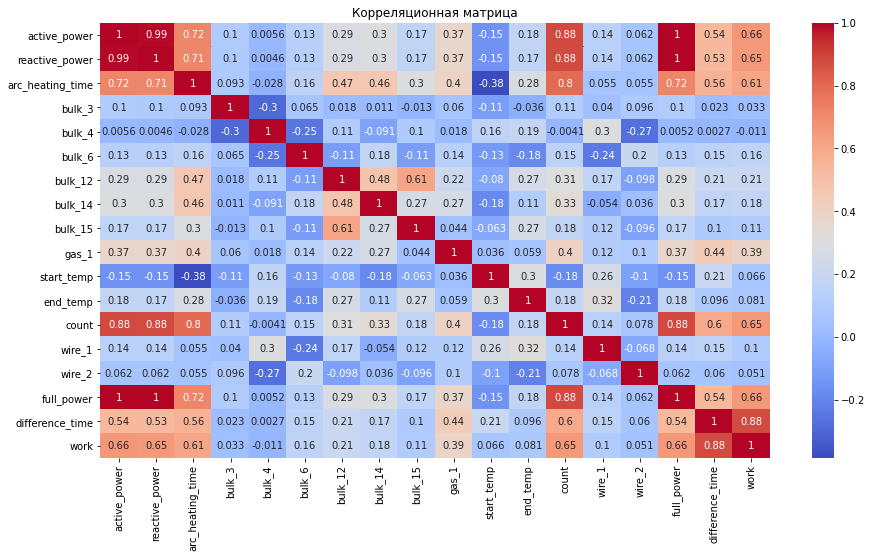

In [70]:
# опредление коэффициентов корреляции
plt.figure(figsize=(15, 8))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm')
plt.title('Корреляционная матрица')
plt.show()

In [71]:
# удаление высококоррелирующих признаков
data = data.drop(['active_power', 'reactive_power'], axis=1)

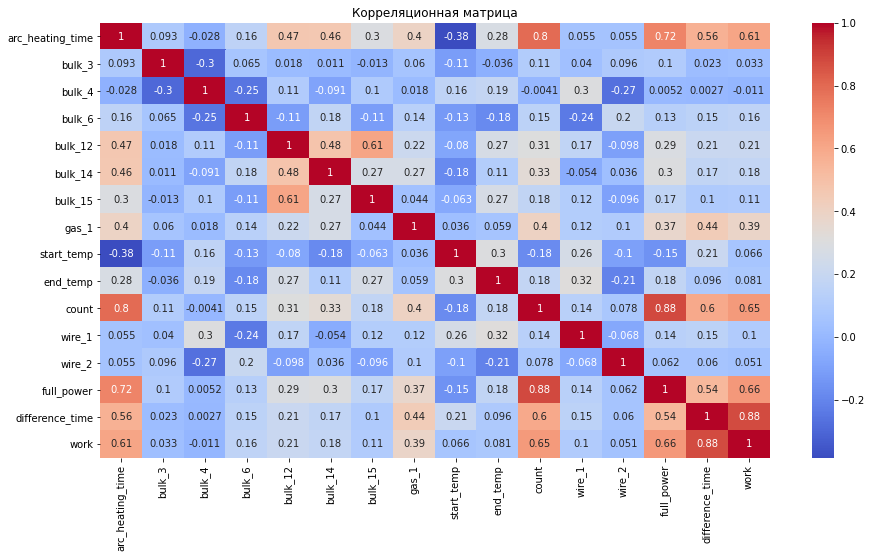

In [72]:
# опредление коэффициентов корреляции
plt.figure(figsize=(15, 8))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm')
plt.title('Корреляционная матрица')
plt.show()

In [73]:
# удаление признаков
data = data.drop(['start_time', 'end_time'], axis=1)

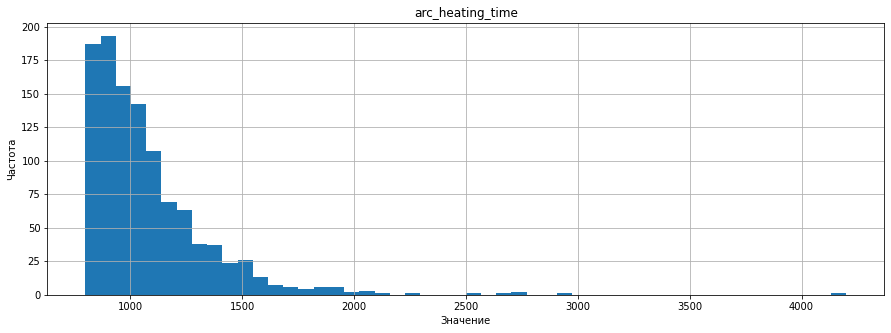

In [74]:
# построение гистограммы по столбцу 'arc_heating_time'
data['arc_heating_time'].hist(bins=50, range = (800, 4200), figsize=(15, 5))
plt.title('arc_heating_time')
plt.ylabel('Частота')
plt.xlabel('Значение');

Данная гистограмма имеет экспоненциальное распределение с пиковым значением, равным 750.

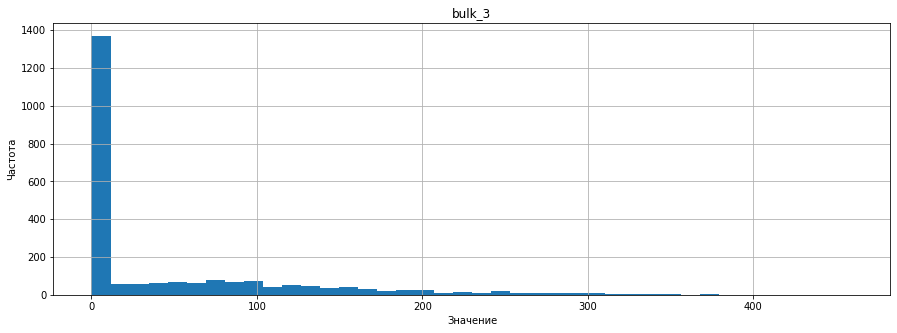

In [75]:
# построение гистограммы по столбцу 'bulk_3'
data['bulk_3'].hist(bins=40, range = (0, 460), figsize=(15, 5))
plt.title('bulk_3')
plt.ylabel('Частота')
plt.xlabel('Значение');

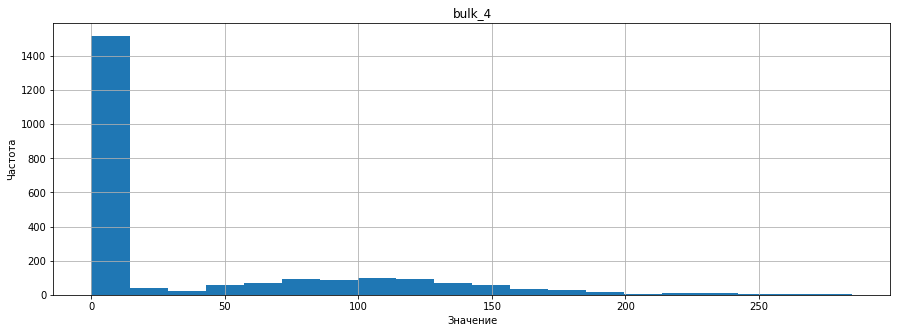

In [76]:
# построение гистограммы по столбцу 'bulk_4'
data['bulk_4'].hist(bins=20, range = (0, 285), figsize=(15, 5))
plt.title('bulk_4')
plt.ylabel('Частота')
plt.xlabel('Значение');

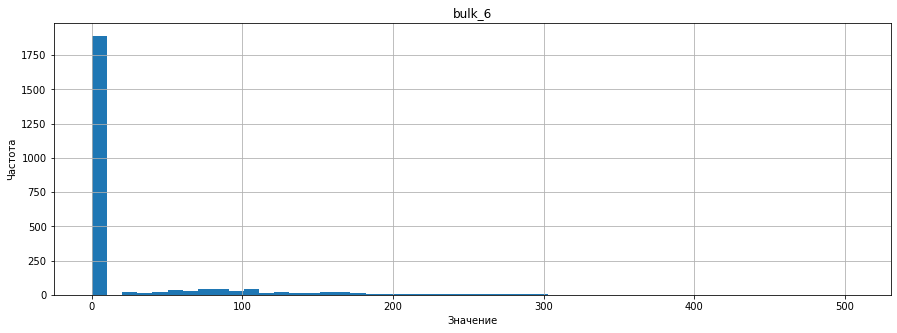

In [77]:
# построение гистограммы по столбцу 'bulk_6'
data['bulk_6'].hist(bins=50, range = (0, 505), figsize=(15, 5))
plt.title('bulk_6')
plt.ylabel('Частота')
plt.xlabel('Значение');

По данным трех полученных гистограмм можно сделать вывод, что столбцы bulk_3, bulk_4, bulk_16 содержит большое количество значений, равным 0, но это связано с тем, что на этапе предобработки пропуски были заполнены нулями, но не были удалены, так как количество пропусков было менее 80%.

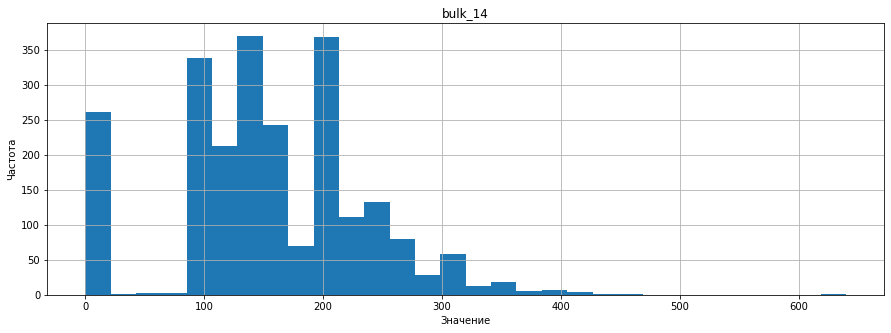

In [78]:
# построение гистограммы по столбцу 'bulk_14'
data['bulk_14'].hist(bins=30, range = (0, 640), figsize=(15, 5))
plt.title('bulk_14')
plt.ylabel('Частота')
plt.xlabel('Значение');

Данная гистограмма показывает, что в столбце bulk_14 есть 4 пика: при значениях равных 0, 100, 140, 200. Пик в районе 0 можно объяснить заполнением пропусков на этапе преобработки.

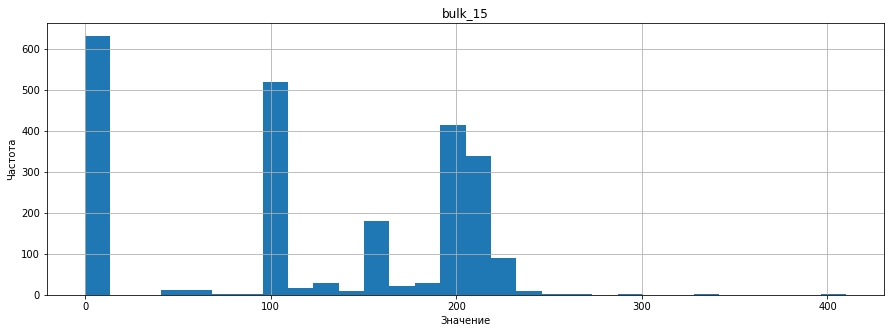

In [79]:
# построение гистограммы по столбцу 'bulk_15'
data['bulk_15'].hist(bins=30, range = (0, 410), figsize=(15, 5))
plt.title('bulk_15')
plt.ylabel('Частота')
plt.xlabel('Значение');

Данная гистограмма показывает, что в столбце bulk_15 есть 3 пика: при значениях равных 0, 100 200. Пик в районе 0 можно объяснить заполнением пропусков на этапе преобработки.

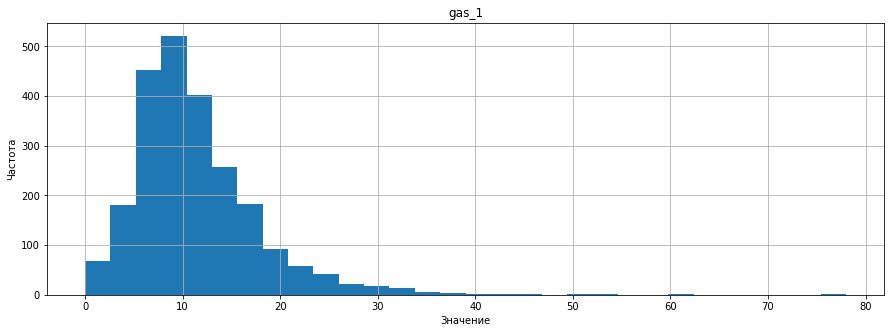

In [80]:
# построение гистограммы по столбцу 'gas_1'
data['gas_1'].hist(bins=30, range = (0, 78), figsize=(15, 5))
plt.title('gas_1')
plt.ylabel('Частота')
plt.xlabel('Значение');

По полученной гистограмме можно сделать вывод, что столбец gas_1 имеет положительно скошенное распределение (хвост с правой стороны). Пик наблюдается при значении, равным 10.

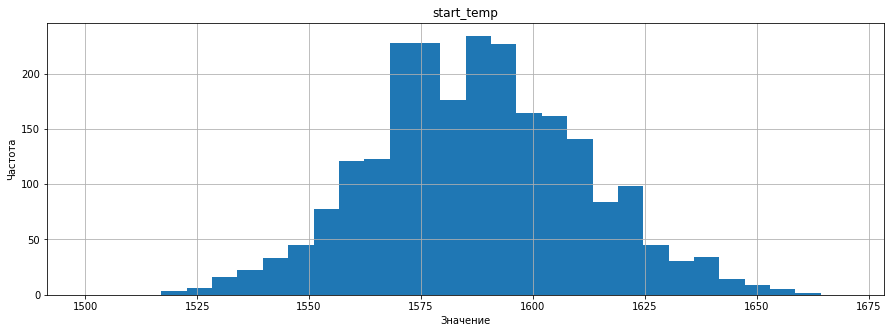

In [81]:
# построение гистограммы по столбцу 'start_temp'
data['start_temp'].hist(bins=30, range = (1500, 1670), figsize=(15, 5))
plt.title('start_temp')
plt.ylabel('Частота')
plt.xlabel('Значение');

Данная диаграмма имеет распределение, близкое к нормальному, но имеет два пика, равные 1570 и 1585.

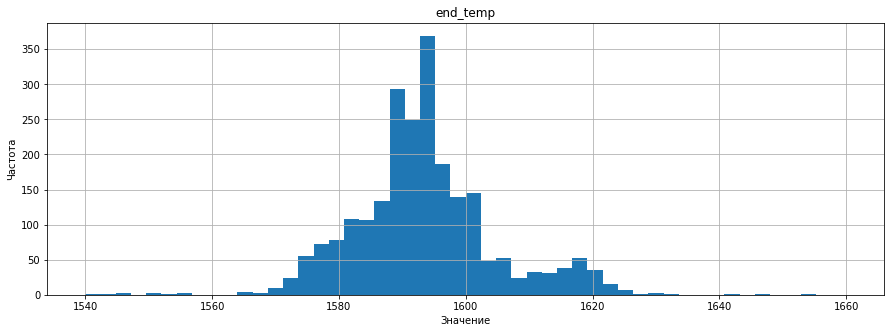

In [82]:
# построение гистограммы по столбцу 'end_temp'
data['end_temp'].hist(bins=50, range = (1540, 1660), figsize=(15, 5))
plt.title('end_temp')
plt.ylabel('Частота')
plt.xlabel('Значение');

Полученная гистограмма имеет близкое к нормальному распределение, но имеет два пика, как и гистограмма столбца start_temp, но пики наблюдаются при значениях 1590 и 1595.

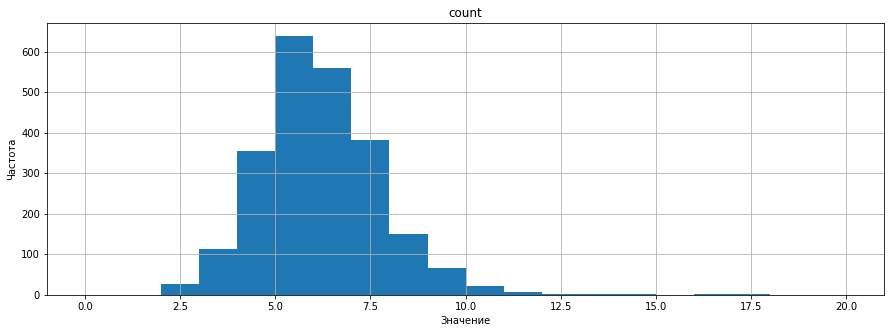

In [83]:
# построение гистограммы по столбцу 'count'
data['count'].hist(bins=20, range = (0, 20), figsize=(15, 5))
plt.title('count')
plt.ylabel('Частота')
plt.xlabel('Значение');

Гистограмма признака count имеет нормальное распределение с пиковым значением, равным 6

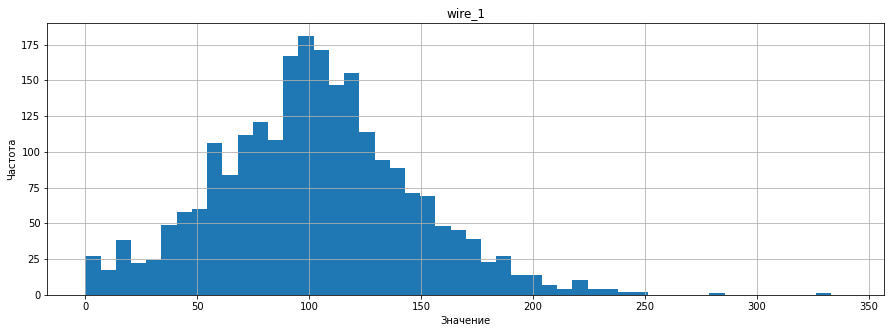

In [84]:
# построение гистограммы по столбцу 'wire_1'
data['wire_1'].hist(bins=50, range = (0, 340), figsize=(15, 5))
plt.title('wire_1')
plt.ylabel('Частота')
plt.xlabel('Значение');

Данная гистограмма имеет нормальное распаределение, но стоит отметить, что она также имеет редкие значения после 250.

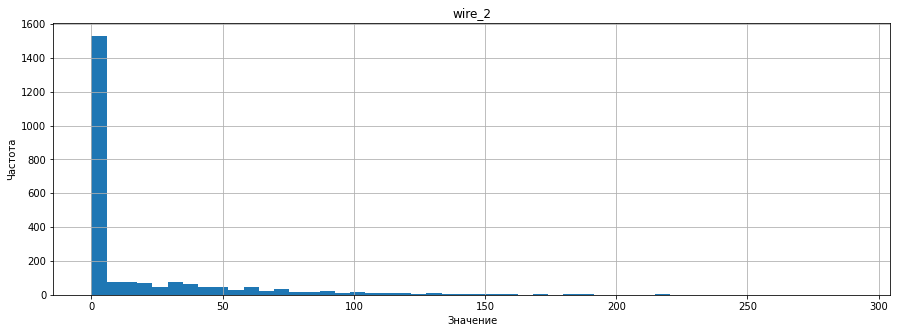

In [85]:
# построение гистограммы по столбцу 'wire_2'
data['wire_2'].hist(bins=50, range = (0, 290), figsize=(15, 5))
plt.title('wire_2')
plt.ylabel('Частота')
plt.xlabel('Значение');

По данной гистограмме можно сделать вывод, что столбец wire_2 содержит большое количество значений, равным 0, но это связано с тем, что на этапе предобработки пропуски были заполнены нулями, но не были удалены, так как количество пропусков было менее 80%.

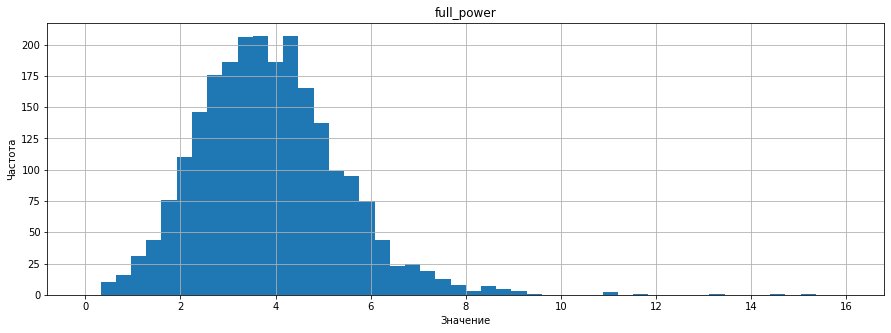

In [86]:
# построение гистограммы по столбцу 'full_power'
data['full_power'].hist(bins=50, range = (0, 16), figsize=(15, 5))
plt.title('full_power')
plt.ylabel('Частота')
plt.xlabel('Значение');

Данная гистограмма имеет нормальное распаределение, но стоит отметить, что она также имеет редкие значения после 10. Стоит отметить, что признак full_power является сгенерированным признаком из признаков active_power и reactive_power.

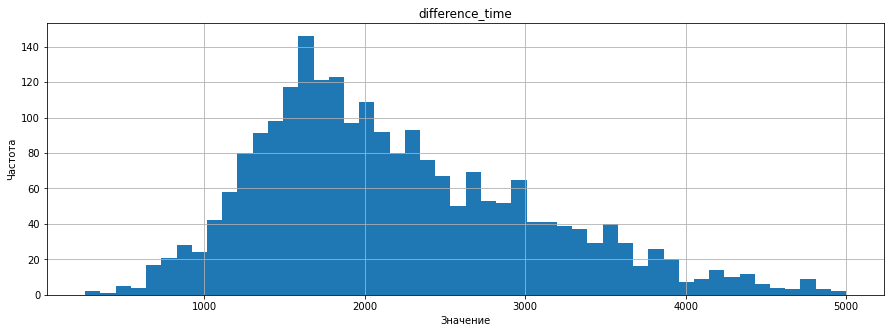

In [87]:
# построение гистограммы по столбцу 'difference_time'
data['difference_time'].hist(bins=50, range = (260, 5000), figsize=(15, 5))
plt.title('difference_time')
plt.ylabel('Частота')
plt.xlabel('Значение');

Гистограмма признака difference_time имеет положительно скошенное распределение (хвост с правой стороны). Пик наблюдается при значении, равным 1600.

**Вывод по четвертому этапу:**\
Был сделан корреляционный анализ данный, в результате которого были удалены признаки, которые сильно коррелируют между собой (более 0.9) - были удалены столбцы 'active_power', 'reactive_power'. Также были удалены признаки 'start_time', 'end_time', так как они не несут важной информации для обучения модели.
По результатам исследовательского анализа данных можно сделать вывод о том, что большая часть признаков имеет нормальное или близкое к нормальному распределения, но часть признаков имеют большое количество значений равное 0. Это объясняется тем, что на этапе предобработки данных пропуски были заполнены нулями. 

## Подготовка данных

In [88]:
# деление датафрейма data на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(columns=['end_temp']),
    data['end_temp'],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE
)

In [89]:
# размер тренировочной выборки 
print(X_train.shape)
print(y_train.shape)

(1746, 15)
(1746,)


In [90]:
# размер тестовой выборки 
print(X_test.shape)
print(y_test.shape)

(583, 15)
(583,)


In [91]:
# создание списков с названиями количественных признаков
num_columns = ['arc_heating_time',
               'bulk_3',
               'bulk_4',
               'bulk_6',
               'bulk_12',
               'bulk_14',
               'bulk_15',
               'gas_1',
               'start_temp',
               'wire_1',
               'wire_2',
               'full_power',
               'difference_time',
               'work',
               'count'
              ]

In [92]:
# создание общего пайплайна для подготовки данных
data_preprocessor = ColumnTransformer(
    [('num', StandardScaler(), num_columns)
    ], 
    remainder='passthrough'
)

**Вывод по пятому этапу:**\
Данные были разделены на обучающую и тестовую выборки в соотношении 75% на 25% и выделены целевой и входные признаки. В качестве целевого признака были значения end_temp. Входные признаки были масштабированы.   

##  Обучение моделей и выбор лучшей модели

In [93]:
# создание итогового пайплайна: подготовка данных и модель
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeRegressor())
    ]
)

In [94]:
param_grid = [

    # словарь для модели DecisionTreeRegressor() 
    {
        'models': [DecisionTreeRegressor()],
        'models__max_depth': [2, 6, 8],
        'models__min_samples_split': [5, 10, 15],
        'models__min_samples_leaf': [1, 2, 5]
    },
   
    # словарь для модели LGBMRegressor() 
    {
        'models': [LGBMRegressor()],
        'models__num_leaves': [15],
        'models__learning_rate': [0.06]
    },
   
    # словарь для модели LinearRegression() 
    {
        'models': [CatBoostRegressor(verbose=False)],
        'models__depth':[5],
        'models__learning_rate': [0.1]
    }
]

In [95]:
grid_search = GridSearchCV(estimator=pipe_final, 
                           param_grid=param_grid,
                           scoring='neg_mean_absolute_error', 
                           cv=5,
                           n_jobs=-1
)
grid_search.fit(X_train, y_train)
print('Лучшая модель и её параметры:\n\n', grid_search.best_estimator_)
print ('MAE лучшей модели на тренировочной выборке:', grid_search.best_score_)

/opt/conda/lib/python3.9/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mix

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['arc_heating_time', 'bulk_3',
                                                   'bulk_4', 'bulk_6',
                                                   'bulk_12', 'bulk_14',
                                                   'bulk_15', 'gas_1',
                                                   'start_temp', 'wire_1',
                                                   'wire_2', 'full_power',
                                                   'difference_time', 'work',
                                                   'count'])])),
                ('models',
                 <catboost.core.CatBoostRegressor object at 0x7fbb58996b20>)])
MAE лучшей модели на тренировочной выборке: -6.035544827729984


In [96]:
# предсказание лучшей модели на тестовой выборке
predictions = grid_search.predict(X_test)
print('MAE на тестовых данных', mean_absolute_error(y_test, predictions))
print('R2 на тестовых данных', r2_score(y_test, predictions))

MAE на тестовых данных 5.869341402296141
R2 на тестовых данных 0.4912934772231128


In [97]:
# инициализация DummyRegressor
dummy_regr = DummyRegressor(strategy='mean')

In [98]:
# обучение на тренировочных данных и получение предсказаний на тестовых данных
dummy_regr.fit(X_train, y_train)
predictions_dummy = dummy_regr.predict(X_test)
print('MAE на тестовых данных', mean_absolute_error(y_test, predictions_dummy))

MAE на тестовых данных 8.140566332455073


**Вывод по шестому этапу:**\
В качестве моделей были выбраны модель DecisionTreeRegressor, CatBoostRegressor(verbose=False) и LGBMRegressor. Для модели DecisionTreeRegressor были перебраны разные значения гиперпараметров. В качестве лучшей модели была отобрана модель CatBoostRegressor с гиперпараметрами depth=5,
learning_rate=0.1. Значение метрики MAE на тренировочной выборке было равно - 6.04. Далее были получены значения метрик MAE и R2 на тестовой выборке - MAE = 5.87 и R2 = 0.49. В конце была обучена константная модель DummyRegressor, значение метрики MAE на тестовых данных получилось 8.14.   

## Анализ важности признаков

In [99]:
# сохранение лучшей модели
best_model = grid_search.best_estimator_

In [100]:
explainer = shap.SamplingExplainer(best_model.named_steps['models'].predict,
                                   best_model.named_steps['preprocessor'].transform(X_train))

In [103]:
shap_values = explainer.shap_values(best_model.named_steps['preprocessor'].transform(X_test))

  0%|          | 0/583 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
shap.summary_plot(shap_values, 
                  best_model.named_steps['preprocessor'].transform(X_test), 
                  feature_names=best_model.named_steps['preprocessor'].get_feature_names_out(), 
                  plot_size=(15,8)
                 )

**Вывод по седьмому этапу:**\
По полученным данным анализа важности признаков можно сказать, что наибольшую важность представляют такие признаки, как arc_heating_time, start_temp и difference_temp. Это объяснимо, ведь целевым признаком является конечная темпертатура. Также стоит отметить, что чем выше значения признаков arc_heating_time и start_temp, тем выше спрогнозированные значения конечной температуры, а в случае с difference_temp ситуация обратная. В случае остальных признаков можно сказать, что они оказывают влияние на конечное значение температуры, но не такое сильное, как у признаков выше.

## Общий вывод

На первом этапе были загружены и обработаны данные из датафреймов data_arc_new, data_bulk_new, data_bulk_time_new, data_gas_new, data_temp_new, data_wire_new, data_wire_time_new. Датафреймы data_bulk_time_new и data_wire_time_new для дальнейшего анализа не понадобятся, так как не несут необходимой для нас информации. В датафреймах data_wire_time_new, data_wire_new, data_temp_new, data_bulk_time_new, data_bulk_new были пропуски, которые впоследствии были заполнены 0. По графику температур видно, что наибольшее кол-во значение приходится на промежуток от 1500 до 1700. Наибольшее кол-во значений газа лежат в промежутке от 0 до 20.\
На втором этапе названия столбцов в каждом датафрейме были приведены к правильному виду, также был изменен тип данных в столбцах с датами. Были удалены строки со значением реактивной мощности < 0 в датафрейме data_arc_new и строки со значением температуры < 1500 в датафрейме data_temp_new, в датафрейме data_temp_new были удалены ключи с одним замером температуры. В датафрейм data_arc_new добавили новый столбец arc_heating_time - время нагрева дугой. В датафрейм data_temp_new были добавлены столбцы 'start_time', 'end_time', 'start_temp', 'end_temp' и 'count'.\
На третьем этапе данные датафреймов data_arc_new, data_bulk_new, data_gas_new, data_temp_new, data_wire_new были объединены в один датафрейм по столбцу 'key', который впоследствии был удален. Также были удалены столбцы, в которых более 80% пропуски. Оставшиеся пропуски были заполнены 0. Были добавлены новые столбцы: full_power и difference_time.\
Был сделан корреляционный анализ данный, в результате которого были удалены признаки, которые сильно коррелируют между собой (более 0.9) - были удалены столбцы 'active_power', 'reactive_power'. Также были удалены признаки 'start_time', 'end_time', так как они не несут важной информации для обучения модели. Также на данном этапе был проведен исследовательский анализ объединенного датасета. ПО его данным можно сказать, что большая часть признаков имеет нормальное распределение, другая часть имеет подаввляющее значений, равным 0, но это связано с заполнением пропусков на этапе предобработки.\
На этапе подготовки данных, данные были разделены на обучающую и тестовую выборки в соотношении 75% на 25%. В качестве целевого признака были значения end_temp. Входные признаки были масштабированы. Для обучения были выбраны три модели DecisionTreeRegressor, CatBoostRegressor(verbose=False) и LGBMRegressor. Для модели DecisionTreeRegressor были перебраны разные значения гиперпараметров. В качестве лучшей модели была отобрана модель CatBoostRegressor с гиперпараметрами depth=5, learning_rate=0.1. Значение метрики MAE на тренировочной выборке было равно - 6.04. Далее были получены значения метрик MAE и R2 на тестовой выборке - MAE = 5.87 и R2 = 0.49. В конце была обучена константная модель DummyRegressor, значение метрики MAE на тестовых данных получилось 8.14.\
При анализе важности признаков было выявлено, что все признаки оказывают влияние на предсказание конечной температуры, но наибольшее влияние обеспечивают такие признаки как arc_heating_time, start_temp и difference_temp. Предсказания прямопропорционально зависят от признаков arc_heating_time и start_temp и обратнопропорционально от признака difference_temp.

**Рекомендации заказчику:**
- сокращение итераций нагрева;
- сокращение времени нагрева дугой при увеличении мощности дуги;
- сокращение этапа обработки благодаря изменению технологического процесса по добавлению объёма подаваемого материала и подаваемых проволочных материалов;

Данные рекомендации можно осуществить с помощью покупки более высококачественного оборудования и проведения анализа о возможности изменения технологического процесса.

